##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Image classification

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/classification"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/classification.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/images/classification.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial shows how to classify images of flowers. It creates an image classifier using a `keras.Sequential` model, and loads data using `preprocessing.image_dataset_from_directory`. You will gain practical experience with the following concepts:

* Efficiently loading a dataset off disk.
* Identifying overfitting and applying techniques to mitigate it, including data augmentation and Dropout.

This tutorial follows a basic machine learning workflow:

1. Examine and understand data
2. Build an input pipeline
3. Build the model
4. Train the model
5. Test the model
6. Improve the model and repeat the process

## Import TensorFlow and other libraries

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
import random
seed_value = 123
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

## Download and explore the dataset

This tutorial uses a dataset of about 3,700 photos of flowers. The dataset contains 5 sub-directories, one per class:

```
flower_photo/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
```

In [4]:
import pathlib
dataset_url = "../../data/interim/train_data"
data_dir = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_url
)
data_dir = pathlib.Path('../../data/interim/train_data')

Found 5002 files belonging to 2 classes.


In [5]:
data_dir

WindowsPath('../../data/interim/train_data')

After downloading, you should now have a copy of the dataset available. There are 3,670 total images:

In [6]:
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

5002


Here are some healthy patients:

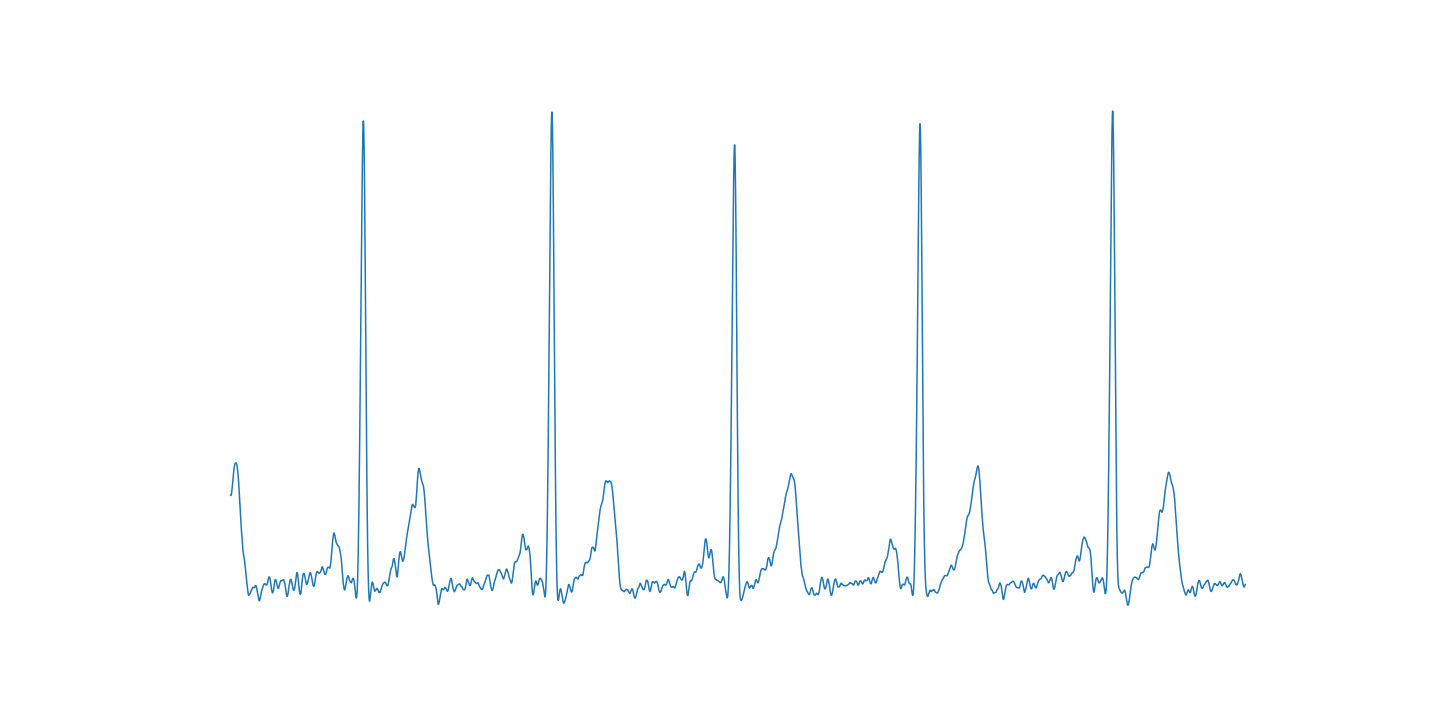

In [7]:
healthy = list(data_dir.glob('healthy_patients/*'))
PIL.Image.open(str(healthy[0]))

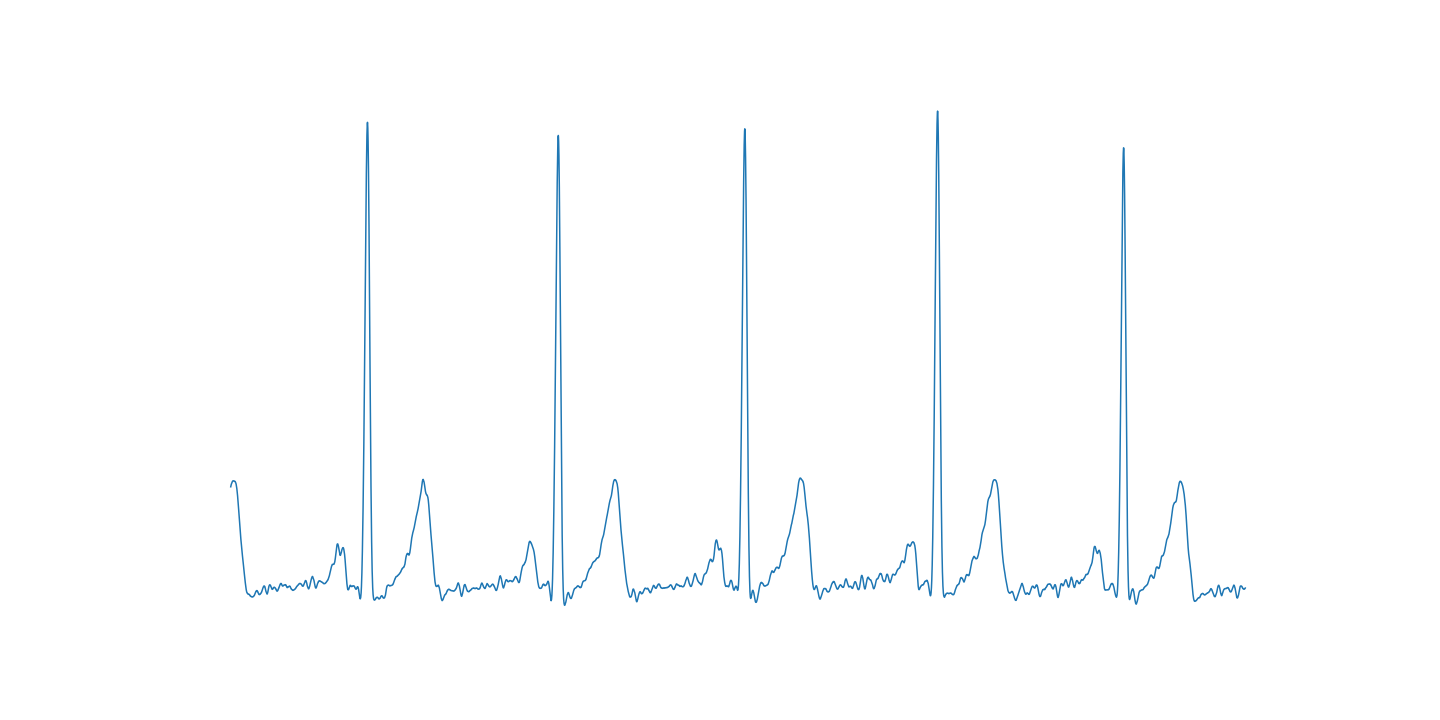

In [8]:
PIL.Image.open(str(healthy[1]))

And some unhealthy:

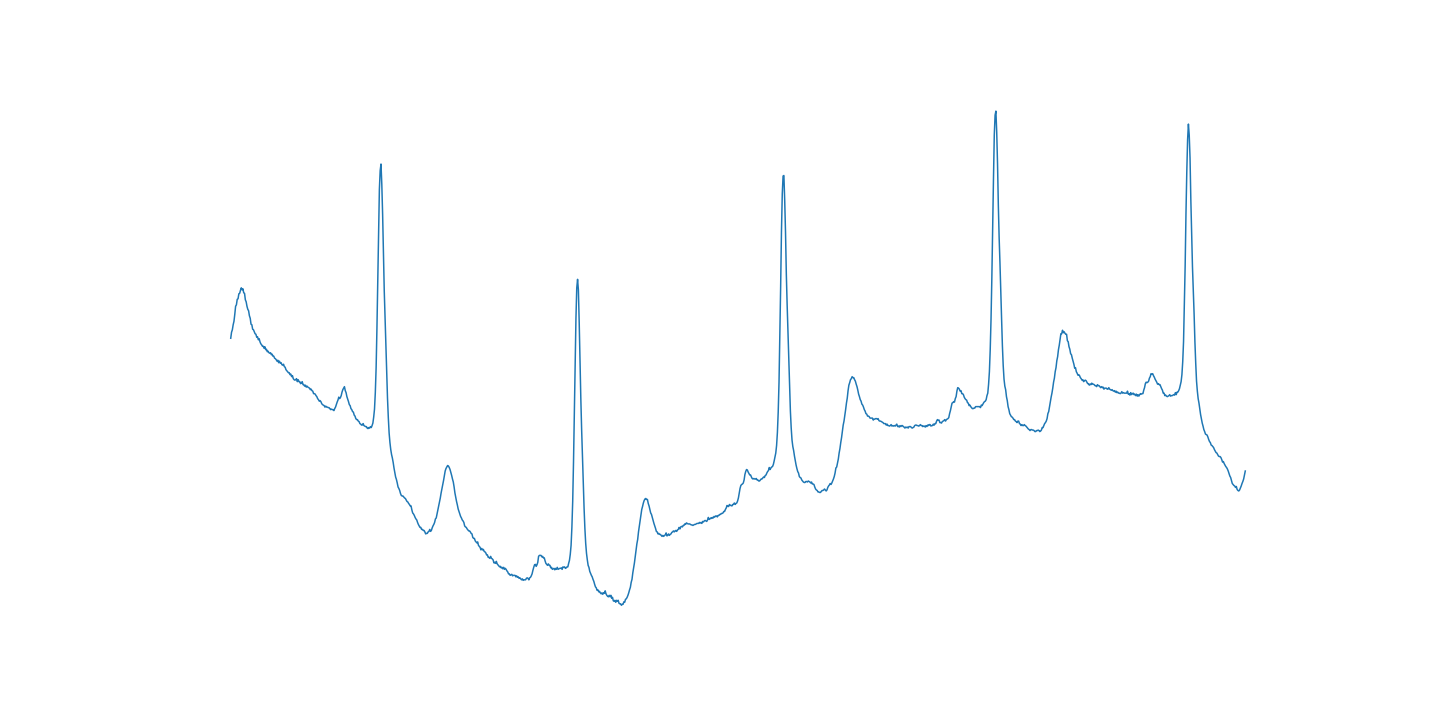

In [9]:
unhealthy = list(data_dir.glob('sudden_death_patients/*'))
PIL.Image.open(str(unhealthy[0]))

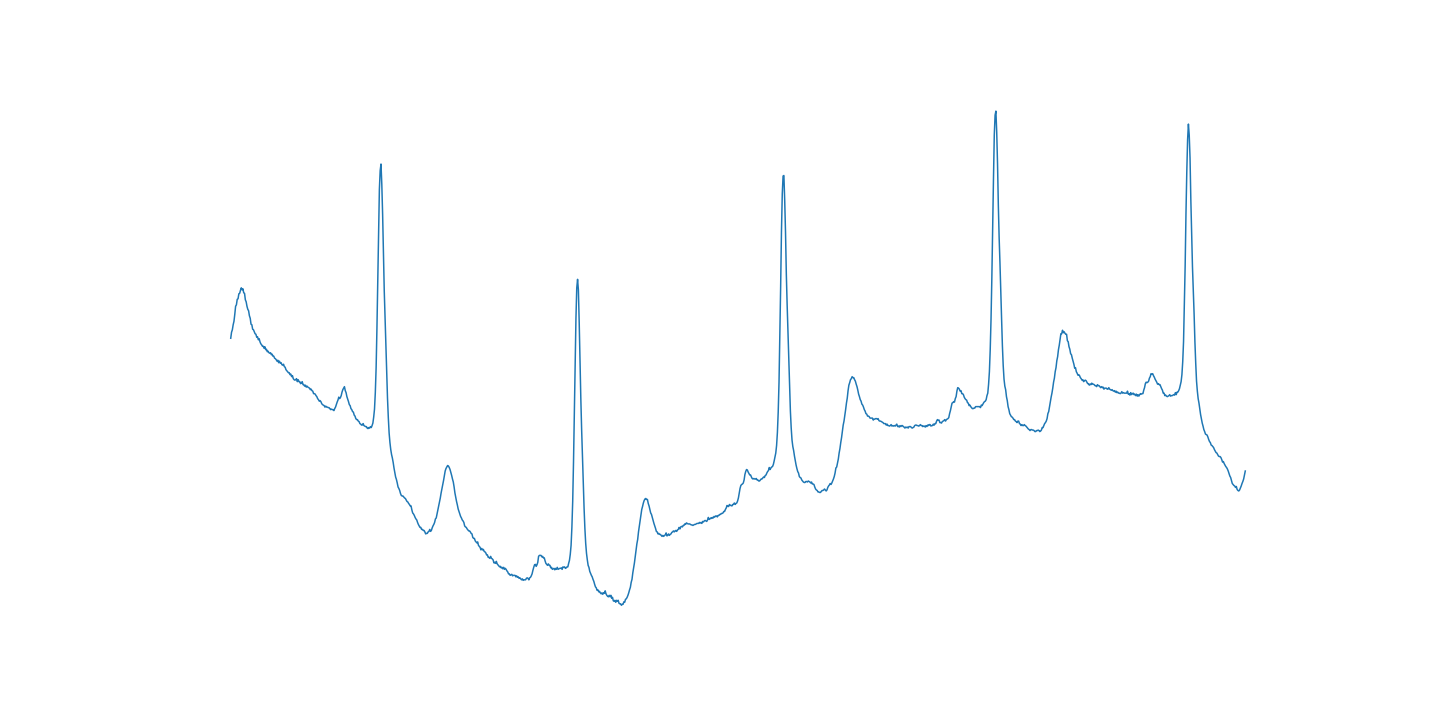

In [10]:
PIL.Image.open(str(unhealthy[0]))

# Load using keras.preprocessing

Let's load these images off disk using the helpful [image_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory) utility. This will take you from a directory of images on disk to a `tf.data.Dataset` in just a couple lines of code. If you like, you can also write your own data loading code from scratch by visiting the [load images](https://www.tensorflow.org/tutorials/load_data/images) tutorial.

## Create a dataset

Define some parameters for the loader:

In [11]:
batch_size = 32
img_height = 200
img_width = 400

It's good practice to use a validation split when developing your model. Let's use 80% of the images for training, and 20% for validation.

In [12]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.01,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5002 files belonging to 2 classes.
Using 4952 files for training.


In [13]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  pathlib.Path('../../data/interim/validacao'),
  validation_split=0.99,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1632 files belonging to 2 classes.
Using 1615 files for validation.


You can find the class names in the `class_names` attribute on these datasets. These correspond to the directory names in alphabetical order.

In [14]:
class_names = train_ds.class_names
print(class_names)

['healthy_patients', 'sudden_death_patients']


## Visualize the data

Here are the first 9 images from the training dataset.

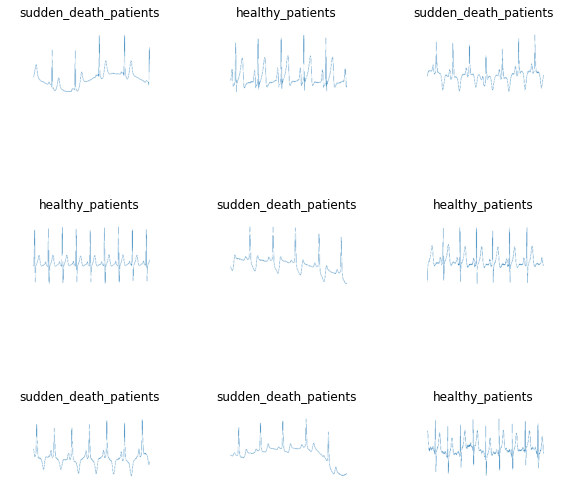

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

You will train a model using these datasets by passing them to `model.fit` in a moment. If you like, you can also manually iterate over the dataset and retrieve batches of images:

In [16]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 200, 400, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images. 

You can call `.numpy()` on the `image_batch` and `labels_batch` tensors to convert them to a `numpy.ndarray`.


## Configure the dataset for performance

Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training. 

Interested readers can learn more about both methods, as well as how to cache data to disk in the [data performance guide](https://www.tensorflow.org/guide/data_performance#prefetching).

In [50]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small. Here, you will standardize values to be in the `[0, 1]` range by using a Rescaling layer.

In [51]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

Note: The Keras Preprocessing utilities and layers introduced in this section are currently experimental and may change.

There are two ways to use this layer. You can apply it to the dataset by calling map:

In [52]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.121568635 1.0


Or, you can include the layer inside your model definition, which can simplify deployment. Let's use the second approach here.

Note: you previously resized images using the `image_size` argument of `image_dataset_from_directory`. If you want to include the resizing logic in your model as well, you can use the [Resizing](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Resizing) layer.

# Create the model

The model consists of three convolution blocks with a max pool layer in each of them. There's a fully connected layer with 128 units on top of it that is activated by a `relu` activation function. This model has not been tuned for high accuracy, the goal of this tutorial is to show a standard approach. 

In [98]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping()

In [104]:
num_classes = 2

In [105]:
num_classes = 2

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## Compile the model

For this tutorial, choose the `optimizers.Adam` optimizer and `losses.SparseCategoricalCrossentropy` loss function. To view training and validation accuracy for each training epoch, pass the `metrics` argument.

In [106]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Model summary

View all the layers of the network using the model's `summary` method:

In [107]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_11 (Rescaling)     (None, 200, 400, 3)       0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 200, 400, 16)      448       
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 100, 200, 16)      0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 100, 200, 32)      4640      
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 50, 100, 32)       0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 50, 100, 64)       18496     
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 25, 50, 64)       

## Train the model

In [108]:
epochs=15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[early_stopping]
)

Epoch 1/15
155/155 [==============================] - 7s 42ms/step - loss: 1.0496 - accuracy: 0.6201 - val_loss: 1.4837 - val_accuracy: 0.4012
Epoch 2/15
155/155 [==============================] - 6s 41ms/step - loss: 0.2737 - accuracy: 0.8874 - val_loss: 0.5962 - val_accuracy: 0.8037
Epoch 3/15
155/155 [==============================] - 6s 41ms/step - loss: 0.1048 - accuracy: 0.9666 - val_loss: 0.2443 - val_accuracy: 0.9183
Epoch 4/15
155/155 [==============================] - 6s 41ms/step - loss: 0.0621 - accuracy: 0.9817 - val_loss: 0.2500 - val_accuracy: 0.9214


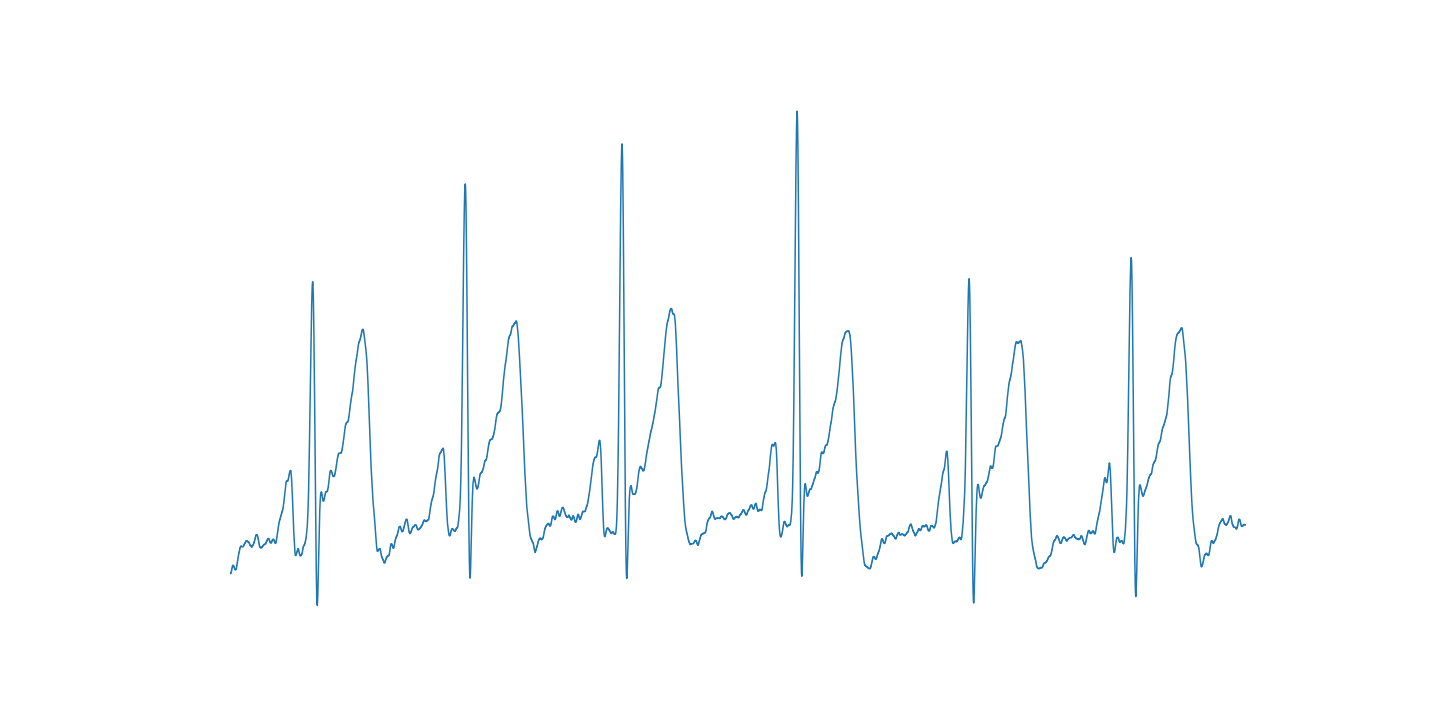

In [109]:
healthy_val = list(pathlib.Path('../../data/interim/validacao').glob('healthy_patients/*'))
PIL.Image.open(str(healthy_val[0]))

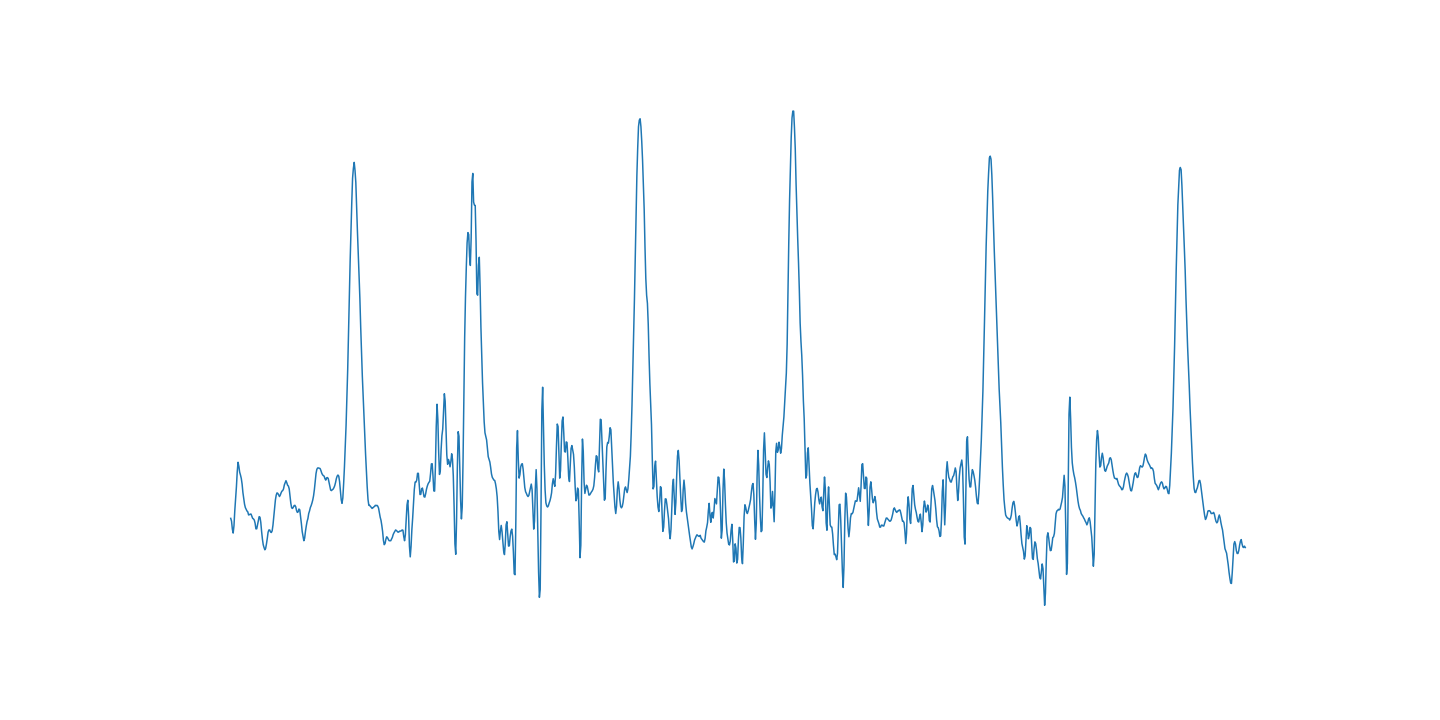

In [110]:
unhealthy_val = list(pathlib.Path('../../data/interim/validacao').glob('sudden_death_patients/*'))
PIL.Image.open(str(unhealthy_val[1]))

#### Now testing into validation

In [111]:
import pandas as pd

In [112]:
df_unhealthy = pd.DataFrame(columns = ['score','class','probability_0','probability_1','both_proba'],index = range(len(unhealthy_val)))

In [113]:
df_healthy = pd.DataFrame(columns = ['score','class','probability_0','probability_1','both_proba'],index = range(len(healthy_val)))

In [114]:
df_unhealthy

,score,class,probability_0,probability_1,both_proba
0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
1195,NaN,NaN,NaN,NaN,NaN
1196,NaN,NaN,NaN,NaN,NaN
1197,NaN,NaN,NaN,NaN,NaN
1198,NaN,NaN,NaN,NaN,NaN


In [115]:
for i in range(len(unhealthy_val)):
    img = keras.preprocessing.image.load_img(
    unhealthy_val[i], target_size=(img_height, img_width)
    )
    
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    score_healthy = float(score[0])
    score_unhealthy = float(score[1])
    
    both_scores = [score_healthy,score_unhealthy]
    
    df_unhealthy['score'].iloc[i] = 100 * np.max(score)
    df_unhealthy['class'].iloc[i] = class_names[np.argmax(score)]
    
    df_unhealthy['probability_0'].iloc[i] = float(score[0])
    df_unhealthy['probability_1'].iloc[i] = float(score[1])
    df_unhealthy['both_proba'].iloc[i] = both_scores

In [116]:
for i in range(len(healthy_val)):
    img = keras.preprocessing.image.load_img(
    healthy_val[i], target_size=(img_height, img_width)
    )
    
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    
    score_healthy = float(score[0])
    score_unhealthy = float(score[1])
    
    both_scores = [score_healthy,score_unhealthy]
    
    df_healthy['score'].iloc[i] = 100 * np.max(score)
    df_healthy['class'].iloc[i] = class_names[np.argmax(score)]

    df_healthy['both_proba'].iloc[i] = both_scores    
    df_healthy['probability_0'].iloc[i] = float(score[0])
    df_healthy['probability_1'].iloc[i] = float(score[1])

In [117]:
df_unhealthy['true'] = 1

In [118]:
df_healthy['true'] = 0

In [119]:
df_healthy.loc[df_healthy['class'] == 'healthy_patients','class'] = 0
df_healthy.loc[df_healthy['class'] == 'sudden_death_patients','class'] = 1

In [120]:
df_unhealthy.loc[df_unhealthy['class'] == 'healthy_patients','class'] = 0
df_unhealthy.loc[df_unhealthy['class'] == 'sudden_death_patients','class'] = 1

In [121]:
df = df_unhealthy.append(df_healthy,ignore_index=True)

In [122]:
df

,score,class,probability_0,probability_1,both_proba,true
0,99.9846,1,0.000154085,0.999846,"[0.0001540848461445421, 0.9998458623886108]",1
1,94.0875,0,0.940875,0.0591254,"[0.9408745765686035, 0.05912541225552559]",1
2,72.8614,1,0.271386,0.728614,"[0.2713856101036072, 0.7286144495010376]",1
3,99.9962,1,3.80436e-05,0.999962,"[3.804355947067961e-05, 0.9999619722366333]",1
4,99.7024,1,0.00297581,0.997024,"[0.0029758079908788204, 0.9970242381095886]",1
...,...,...,...,...,...,...
1627,50.4714,0,0.504714,0.495286,"[0.5047144293785095, 0.4952855408191681]",0
1628,99.9959,0,0.999959,4.13298e-05,"[0.9999586343765259, 4.1329796658828855e-05]",0
1629,99.3536,0,0.993536,0.00646452,"[0.9935355186462402, 0.006464515812695026]",0
1630,99.2322,0,0.992322,0.00767849,"[0.9923215508460999, 0.007678486872464418]",0


In [123]:
pd.qcut(df['probability_1'],3,labels=['Low Risk','Medium Risk','High Risk']).value_counts()

High Risk      544
Medium Risk    544
Low Risk       544
Name: probability_1, dtype: int64

In [124]:
df['class'].value_counts()

1    1161
0     471
Name: class, dtype: int64

In [125]:
df_unhealthy['class'].value_counts()

1    1112
0      88
Name: class, dtype: int64

In [126]:
1112/1200

0.9266666666666666

In [127]:
df_healthy['class'].value_counts()

0    383
1     49
Name: class, dtype: int64

In [128]:
383/432

0.8865740740740741

In [129]:
df['class'] = df['class'].astype(int)

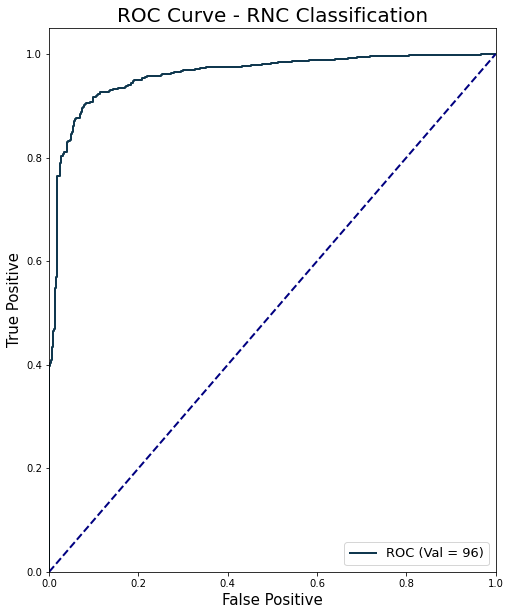

Accuracy, Gini e ROC Curve Area (Val Data):  91.61 92.0 96.0


In [130]:
y_pred_logreg_val = df['class']
y_score_logreg_val = df['probability_1']

# 1) Accuracy Calculation
from sklearn.metrics import accuracy_score

#Val
acc_logreg_val = round(accuracy_score(y_pred_logreg_val, df['true']) * 100, 2)

# 2) Area under the curve (ROC and Gini)
from sklearn.metrics import roc_curve, auc

# Val
fpr_logreg_val, tpr_logreg_val, thresholds = roc_curve(df['true'], y_score_logreg_val)
roc_auc_logreg_val = 100*round(auc(fpr_logreg_val, tpr_logreg_val), 2)
gini_logreg_val = 100*round((2*roc_auc_logreg_val/100 - 1), 2)


# 3) Grafic of ROC curve
import matplotlib.pyplot as plt

plt.figure(figsize=(8,10))

lw = 2


plt.plot(fpr_logreg_val, tpr_logreg_val, color='#10384f',lw=lw, label='ROC (Val = %0.0f)' % roc_auc_logreg_val)


plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive', fontsize=15)
plt.ylabel('True Positive', fontsize=15)
plt.legend(loc="lower right")
plt.legend(fontsize=13, loc = 'lower right') 
plt.title('ROC Curve - RNC Classification', fontsize=20)
plt.show()

print('Accuracy, Gini e ROC Curve Area (Val Data): ',acc_logreg_val, gini_logreg_val, roc_auc_logreg_val)

#Colocr quais cores?
#tons de azul - val escuro

## Specificity x Sensibility

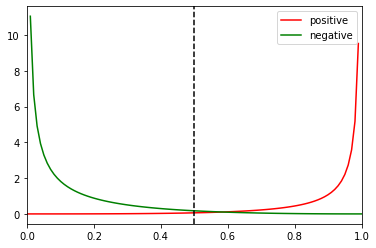

In [131]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

test_y = df['class']
predicted_y_probs = df['probability_1']

def estimate_beta(X):
    xbar = np.mean(X)
    vbar = np.var(X,ddof=1)
    alphahat = xbar*(xbar*(1-xbar)/vbar - 1)
    betahat = (1-xbar)*(xbar*(1-xbar)/vbar - 1)
    return alphahat, betahat

positive_beta_estimates = estimate_beta(predicted_y_probs[test_y == 1])
negative_beta_estimates = estimate_beta(predicted_y_probs[test_y == 0])

unit_interval = np.linspace(0,1,100)
plt.plot(unit_interval, scipy.stats.beta.pdf(unit_interval, *positive_beta_estimates), c='r', label="positive")
plt.plot(unit_interval, scipy.stats.beta.pdf(unit_interval, *negative_beta_estimates), c='g', label="negative")

# Show the threshold.
plt.axvline(0.5, c='black', ls='dashed')
plt.xlim(0,1)

# Add labels
plt.legend()

## Model Separation

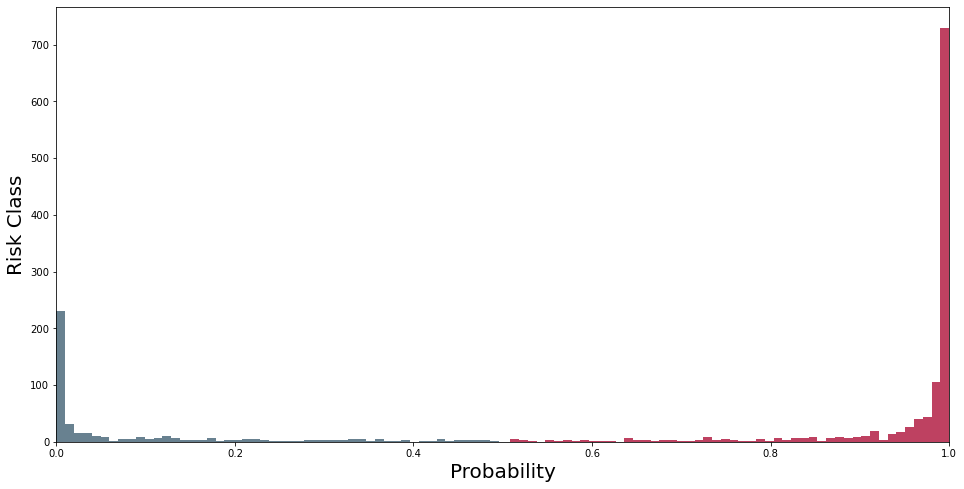

In [132]:
# codes separation

LRscores_by_class = zip(df['probability_1'], df['class'])
OneScores = [x[0] for x in LRscores_by_class if x[1]==1]
LRscores_by_class = zip(df['probability_1'], df['class'])
ZeroScores = [x[0] for x in LRscores_by_class if x[1]==0]

plt.subplots(figsize=(16,8))

(n1, bins1,paches1) = plt.hist([x for x in ZeroScores if x >0.],\

bins=50, alpha=0.63, color="#10384f", histtype='stepfilled')

(n2, bins2, paches2) = plt.hist([x for x in OneScores if x >0.],\

bins=50,alpha=0.8, color="#ae123a", histtype='stepfilled')

plt.xlim([0, 1])


plt.title('', size=27)
plt.xlabel('Probability', size=20)
plt.ylabel('Risk Class', size=20)
plt.rcParams['xtick.labelsize'] = 17
plt.rcParams['ytick.labelsize'] = 17

plt.show()

## To do list
    - Tunada
    - Curva Roc
    - Especificidade x Sensibilidade

Pegar um paciente de sudden_death e pegar vários trechinhos de 5s antes da fibrilação

## Validação final

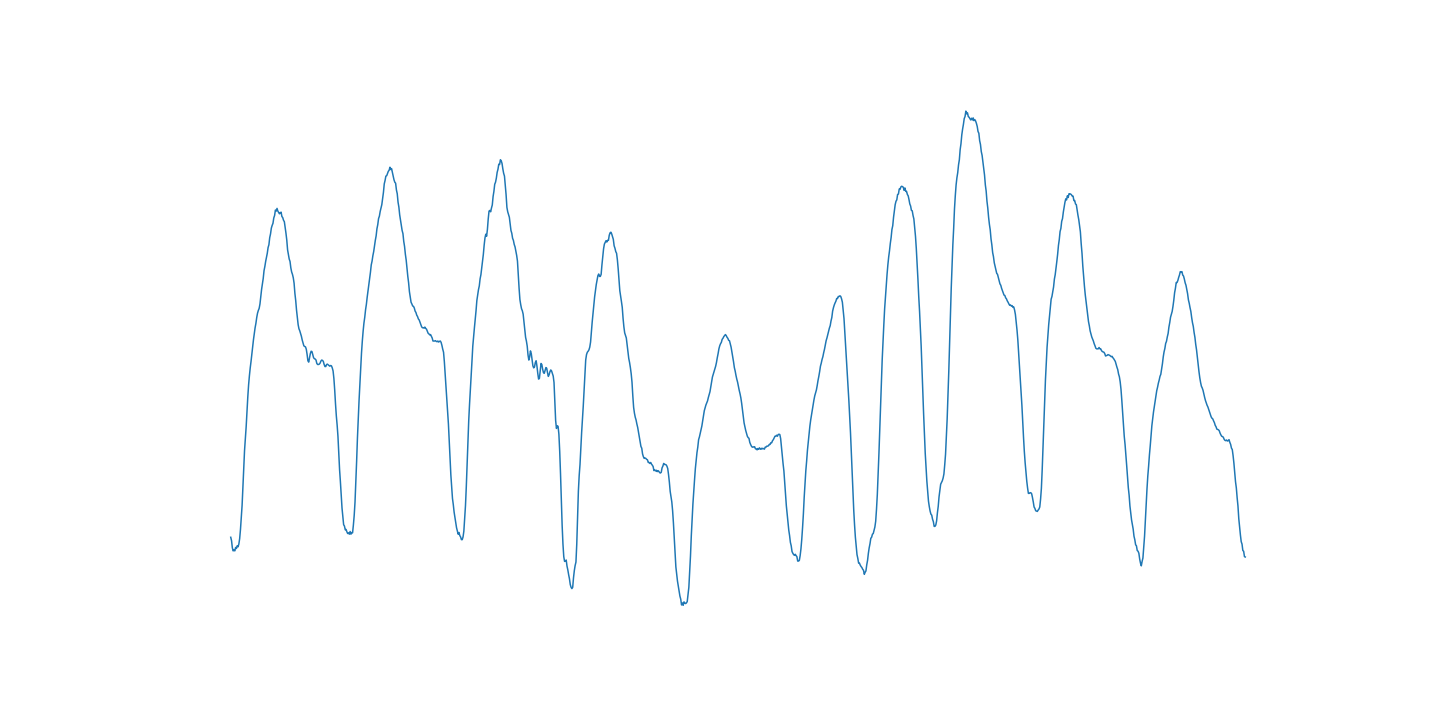

In [133]:
unhealthy_final = list(pathlib.Path('../../data/interim/').glob('validacao_final/*'))
PIL.Image.open(str(unhealthy_final[1]))

#### Now testing into validation

In [134]:
import pandas as pd

In [135]:
df_unhealthy_final = pd.DataFrame(columns = ['score','class','probability_0','probability_1','both_proba'],index = range(len(unhealthy_final)))

In [136]:
for i in range(len(unhealthy_final)):
    img = keras.preprocessing.image.load_img(
    unhealthy_final[i], target_size=(img_height, img_width)
    )
    
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    score_healthy = float(score[0])
    score_unhealthy = float(score[1])
    
    both_scores = [score_healthy,score_unhealthy]
    
    df_unhealthy_final['score'].iloc[i] = 100 * np.max(score)
    df_unhealthy_final['class'].iloc[i] = class_names[np.argmax(score)]
    
    df_unhealthy_final['probability_0'].iloc[i] = float(score[0])
    df_unhealthy_final['probability_1'].iloc[i] = float(score[1])
    df_unhealthy_final['both_proba'].iloc[i] = both_scores

In [137]:
df_unhealthy_final['true'] = 'sudden_death_patients'

In [138]:
df_unhealthy_final['class'].value_counts()

sudden_death_patients    2081
healthy_patients          319
Name: class, dtype: int64

In [139]:
df_unhealthy_final['score'] = df_unhealthy_final['score'].astype(float)

In [140]:
df_unhealthy_final.loc[df_unhealthy_final['class'] == 'healthy_patients','class'] = 'erro'
df_unhealthy_final.loc[df_unhealthy_final['class'] == 'sudden_death_patients','class'] = 'acerto'

In [141]:
df_healthy.loc[df_healthy['class'] == 0,'class'] = 'acerto'
df_healthy.loc[df_healthy['class'] == 1,'class'] = 'erro'

In [142]:
grouped_unhealthy = df_unhealthy_final.groupby(['class']).agg({'class' : 'count'}).rename(columns = {'class' : 'count_correct'}).reset_index()

In [143]:
grouped_unhealthy['count_correct'] = (grouped_unhealthy['count_correct'] / 2400) * 100

In [144]:
grouped_unhealthy

,class,count_correct
0,acerto,86.708333
1,erro,13.291667


In [145]:
import seaborn as sns

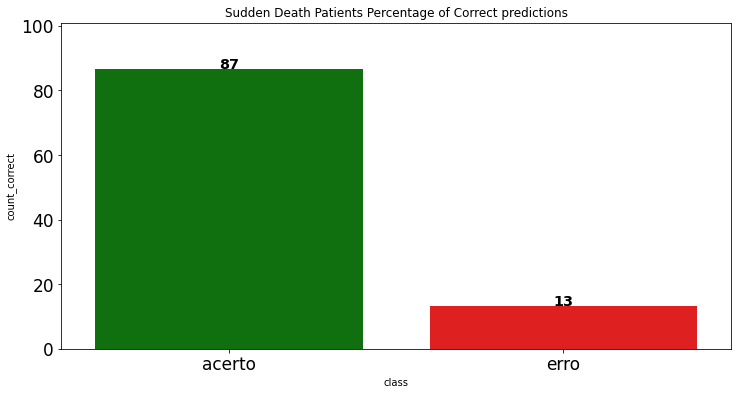

In [146]:
plt.figure(figsize=[12,6])
colors = ['green','red']
ax = sns.barplot(x=grouped_unhealthy['class'],y=grouped_unhealthy['count_correct'],palette=colors)
plt.title('Sudden Death Patients Percentage of Correct predictions')
plt.xticks(range(2))
plt.ylim(0,101)
for index, row in grouped_unhealthy.iterrows():
    ax.text(row.name,row['count_correct'], round(row['count_correct']), color='black', ha="center",fontsize='x-large',weight='bold')
plt.show()

In [147]:
grouped_healthy = df_healthy.groupby(['class']).agg({'class' : 'count'}).rename(columns = {'class' : 'count_correct'}).reset_index()

In [148]:
grouped_healthy['count_correct'] = (grouped_healthy['count_correct'] / 432) * 100

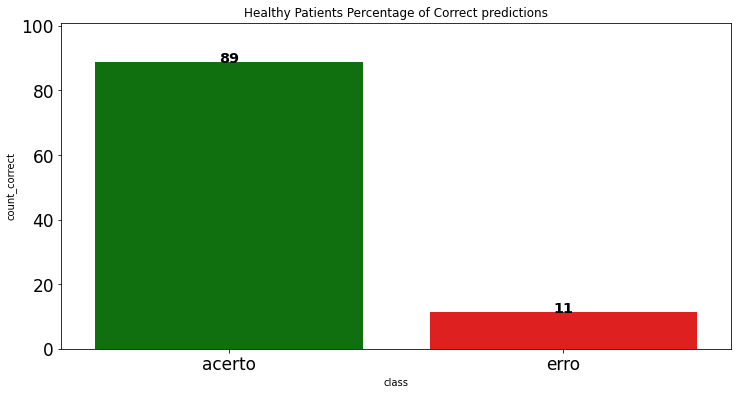

In [149]:
plt.figure(figsize=[12,6])
ax = sns.barplot(x=grouped_healthy['class'],y=grouped_healthy['count_correct'],palette=colors)
plt.title('Healthy Patients Percentage of Correct predictions')
plt.ylim(0,101)

for index, row in grouped_healthy.iterrows():
    ax.text(row.name,row['count_correct'], round(row['count_correct']), color='black', ha="center",fontsize='x-large',weight='bold')
plt.show()

In [150]:
len(df_healthy)

432

## Modelo está otimo, salvando o modelo!

In [152]:
model.save('../../models/rnc_image_classification_model')

INFO:tensorflow:Assets written to: ../../models/rnc_image_classification_model\assets
